### <b>Dataset Download</b>

* This dataset has total <b>1,400 images</b>. (train: 1,000 / val: 200 / test: 200)

<pre>
<b>Dataset</b>/
    <b>train</b>/
        <b>cats</b>/
          500 images
        <b>dogs</b>/
          500 images
    <b>val</b>/
        <b>cats</b>/
          100 images
        <b>dogs</b>/
          100 images
    <b>test</b>/
        <b>cats</b>/
          100 images
        <b>dogs</b>/
          100 images
</pre>

In [1]:
!git clone https://github.com/ndb796/Poison-Frogs-OneShotKillAttack-PyTorch
%cd Poison-Frogs-OneShotKillAttack-PyTorch

Cloning into 'Poison-Frogs-OneShotKillAttack-PyTorch'...
remote: Enumerating objects: 1424, done.
remote: Counting objects: 100% (1424/1424), done.
remote: Compressing objects: 100% (1421/1421), done.
remote: Total 1424 (delta 2), reused 1412 (delta 0), pack-reused 0
Receiving objects: 100% (1424/1424), 30.06 MiB | 45.06 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/Poison-Frogs-OneShotKillAttack-PyTorch


### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './simple_dog_and_cat_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms_val)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=16, shuffle=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=16, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_datasets))
print('Validation dataset size:', len(val_datasets))
print('Test dataset size:', len(test_datasets))

class_names = train_datasets.classes
print('Class names:', class_names)

Train dataset size: 1000
Validation dataset size: 200
Test dataset size: 200
Class names: ['cat', 'dog']


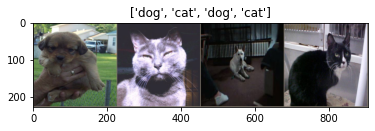

In [16]:
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Define Model</b>

* A fixed ResNet feature extractor is switched to the <b>eval() mode</b> because ResNet has a batch normalization layer.
* We focus on a transfer learning retraining only the FC layer.

In [17]:
class StudentNetwork(nn.Module):
    def __init__(self):
        super(StudentNetwork, self).__init__()

        # load a pre-trained model for the feature extractor
        self.feature_extractor = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1]).eval()
        self.fc = nn.Linear(512, 2) # binary classification (num_of_class == 2)

        # fix the pre-trained network
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, images):
        features = self.feature_extractor(images)
        x = torch.flatten(features, 1)
        outputs = self.fc(x)
        return features, outputs

In [18]:
model = StudentNetwork().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### <b>Generate Poison Instance</b>

* <b>A base instance</b>: a randomly selected cat image from the test dataset.
* <b>A target instance</b>: a randomly selected dog image from the test dataset.

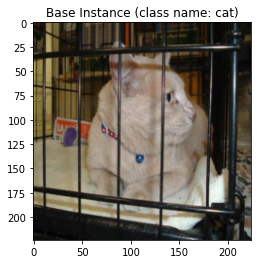

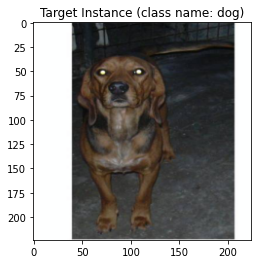

In [20]:
base_instance = None
target_instance = None

for inputs, labels in test_dataloader:
    for i in range(inputs.shape[0]):
        if labels[i].item() == 0: # if it's a cat
            base_instance = inputs[i].unsqueeze(0).to(device)
        elif labels[i].item() == 1: # if it's a dog
            target_instance = inputs[i].unsqueeze(0).to(device)


imshow(base_instance[0].cpu(), f'Base Instance (class name: {class_names[0]})')
imshow(target_instance[0].cpu(), f'Target Instance (class name: {class_names[1]})')

* In this code, we utilize <b>L-infinity</b> bound perturbation because it requires relatively small iterations.

Feature loss: 1.1012074947357178, Image loss: 8.751502721128558e-17, Time: 0.10569548606872559
Feature loss: 0.010132059454917908, Image loss: 0.003300911281257868, Time: 3.128680467605591
Feature loss: 0.0053098248317837715, Image loss: 0.004550212528556585, Time: 5.995355129241943
Feature loss: 0.003522370243445039, Image loss: 0.005405725911259651, Time: 8.935247898101807
Feature loss: 0.0026931094471365213, Image loss: 0.006062916945666075, Time: 11.642061948776245
Feature loss: 0.0021994602866470814, Image loss: 0.006624062079936266, Time: 14.456345558166504
Feature loss: 0.0018436081008985639, Image loss: 0.0071142506785690784, Time: 17.362298250198364
Feature loss: 0.0015479159774258733, Image loss: 0.007564264815300703, Time: 20.20298171043396
Feature loss: 0.001367615768685937, Image loss: 0.007967150770127773, Time: 23.00160574913025
Feature loss: 0.0011524779256433249, Image loss: 0.008336273953318596, Time: 25.760669231414795
Feature loss: 0.0010941928485408425, Image loss:

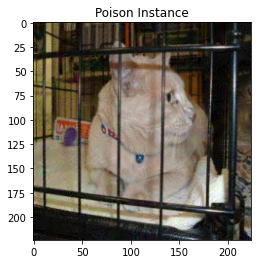

In [21]:
mean_tensor = torch.from_numpy(np.array([0.485, 0.456, 0.406]))
std_tensor = torch.from_numpy(np.array([0.229, 0.224, 0.225]))

unnormalized_base_instance = base_instance.clone()
unnormalized_base_instance[:, 0, :, :] *= std_tensor[0]
unnormalized_base_instance[:, 0, :, :] += mean_tensor[0]
unnormalized_base_instance[:, 1, :, :] *= std_tensor[1]
unnormalized_base_instance[:, 1, :, :] += mean_tensor[1]
unnormalized_base_instance[:, 2, :, :] *= std_tensor[2]
unnormalized_base_instance[:, 2, :, :] += mean_tensor[2]

perturbed_instance = unnormalized_base_instance.clone()
target_features, outputs = model(target_instance)

transforms_normalization = transforms.Compose([
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

epsilon = 16 / 255
alpha = 0.05 / 255

start_time = time.time()
for i in range(5000):
    perturbed_instance.requires_grad = True

    poison_instance = transforms_normalization(perturbed_instance)
    poison_features, _ = model(poison_instance)

    feature_loss = nn.MSELoss()(poison_features, target_features)
    image_loss = nn.MSELoss()(poison_instance, base_instance)
    loss = feature_loss + image_loss / 1e2
    loss.backward()

    signed_gradient = perturbed_instance.grad.sign()

    perturbed_instance = perturbed_instance - alpha * signed_gradient
    eta = torch.clamp(perturbed_instance - unnormalized_base_instance, -epsilon, epsilon)
    perturbed_instance = torch.clamp(unnormalized_base_instance + eta, 0, 1).detach()

    if i == 0 or (i + 1) % 500 == 0:
        print(f'Feature loss: {feature_loss}, Image loss: {image_loss}, Time: {time.time() - start_time}')

poison_instance = transforms_normalization(perturbed_instance)
imshow(poison_instance[0].cpu(), 'Poison Instance')

### <b>Training (Poisoning) Phase</b>

* We <b>don't need</b> to switch a model state to <b>model.train()</b> or <b>model.eval()</b> because we train the only last FC layer.
* And we should use a ResNet as a fixed feature extractor that is eval() mode.

[Train #0] Loss: 0.1523 Acc: 95.1000% Time: 4.5704s
[Validation #0] Loss: 0.3253 Acc: 92.5000% Time: 5.6569s


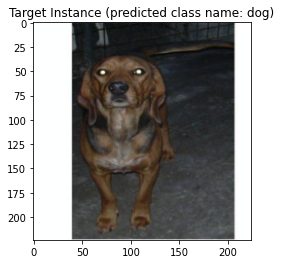

[Predicted Confidence] cat: 0.005685454234480858 | dog: 0.9943144917488098
[Train #1] Loss: 0.1178 Acc: 96.3000% Time: 10.4267s
[Validation #1] Loss: 0.1260 Acc: 96.5000% Time: 11.5241s
[Train #2] Loss: 0.0494 Acc: 98.7000% Time: 16.1719s
[Validation #2] Loss: 0.1005 Acc: 95.5000% Time: 17.2675s
[Train #3] Loss: 0.1141 Acc: 97.2000% Time: 21.8985s
[Validation #3] Loss: 0.1040 Acc: 95.5000% Time: 23.0210s
[Train #4] Loss: 0.0282 Acc: 99.3000% Time: 27.6911s
[Validation #4] Loss: 0.2104 Acc: 95.0000% Time: 28.7759s
[Train #5] Loss: 0.0493 Acc: 98.2000% Time: 33.3540s
[Validation #5] Loss: 0.3581 Acc: 93.5000% Time: 34.4692s


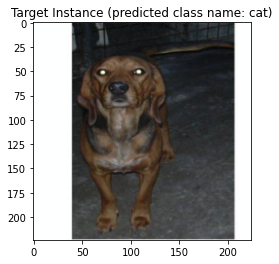

[Predicted Confidence] cat: 0.8254102468490601 | dog: 0.17458976805210114
[Train #6] Loss: 0.0249 Acc: 99.2000% Time: 39.2105s
[Validation #6] Loss: 0.1044 Acc: 95.5000% Time: 40.3308s
[Train #7] Loss: 0.0660 Acc: 98.4000% Time: 44.9617s
[Validation #7] Loss: 0.1698 Acc: 94.5000% Time: 46.0611s
[Train #8] Loss: 0.1081 Acc: 97.5000% Time: 50.7036s
[Validation #8] Loss: 0.2137 Acc: 96.5000% Time: 51.8007s
[Train #9] Loss: 0.0194 Acc: 99.4000% Time: 56.3597s
[Validation #9] Loss: 0.4329 Acc: 93.0000% Time: 57.4157s
[Train #10] Loss: 0.0243 Acc: 99.1000% Time: 62.0327s
[Validation #10] Loss: 0.1633 Acc: 95.5000% Time: 63.1182s


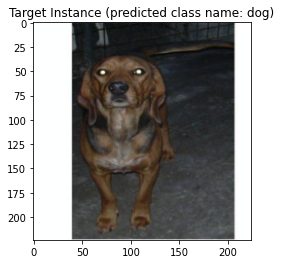

[Predicted Confidence] cat: 0.3365797996520996 | dog: 0.6634202599525452
[Train #11] Loss: 0.0066 Acc: 99.8000% Time: 67.8397s
[Validation #11] Loss: 0.1450 Acc: 95.5000% Time: 68.8994s
[Train #12] Loss: 0.0030 Acc: 99.8000% Time: 73.5097s
[Validation #12] Loss: 0.1320 Acc: 95.5000% Time: 74.6085s
[Train #13] Loss: 0.0010 Acc: 100.0000% Time: 79.2432s
[Validation #13] Loss: 0.2092 Acc: 94.0000% Time: 80.3401s
[Train #14] Loss: 0.0007 Acc: 100.0000% Time: 84.8936s
[Validation #14] Loss: 0.1462 Acc: 95.5000% Time: 86.0154s
[Train #15] Loss: 0.0003 Acc: 100.0000% Time: 90.6584s
[Validation #15] Loss: 0.1542 Acc: 96.0000% Time: 91.7700s


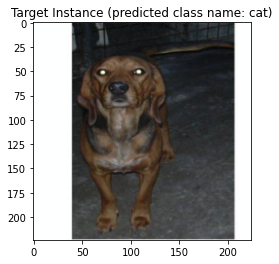

[Predicted Confidence] cat: 0.9791151285171509 | dog: 0.02088489755988121
[Train #16] Loss: 0.0004 Acc: 100.0000% Time: 96.6519s
[Validation #16] Loss: 0.1405 Acc: 96.0000% Time: 97.8015s
[Train #17] Loss: 0.0006 Acc: 100.0000% Time: 102.4028s
[Validation #17] Loss: 0.1435 Acc: 96.0000% Time: 103.5164s
[Train #18] Loss: 0.0005 Acc: 100.0000% Time: 108.2424s
[Validation #18] Loss: 0.1436 Acc: 96.5000% Time: 109.3721s
[Train #19] Loss: 0.0003 Acc: 100.0000% Time: 114.0436s
[Validation #19] Loss: 0.1456 Acc: 96.0000% Time: 115.1277s
[Train #20] Loss: 0.0004 Acc: 100.0000% Time: 119.7661s
[Validation #20] Loss: 0.1523 Acc: 95.0000% Time: 120.8972s


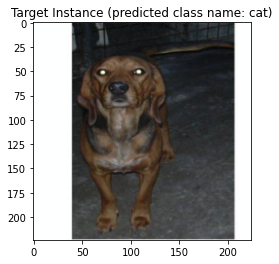

[Predicted Confidence] cat: 0.9829075932502747 | dog: 0.017092421650886536
[Train #21] Loss: 0.0003 Acc: 100.0000% Time: 125.7142s
[Validation #21] Loss: 0.1353 Acc: 96.0000% Time: 126.8443s
[Train #22] Loss: 0.0003 Acc: 100.0000% Time: 131.4821s
[Validation #22] Loss: 0.1341 Acc: 96.0000% Time: 132.5850s
[Train #23] Loss: 0.0003 Acc: 100.0000% Time: 137.2025s
[Validation #23] Loss: 0.1668 Acc: 95.0000% Time: 138.2944s
[Train #24] Loss: 0.0003 Acc: 100.0000% Time: 142.9308s
[Validation #24] Loss: 0.1572 Acc: 95.0000% Time: 144.0527s
[Train #25] Loss: 0.0002 Acc: 100.0000% Time: 148.7117s
[Validation #25] Loss: 0.1554 Acc: 95.0000% Time: 149.8128s


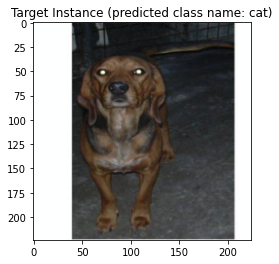

[Predicted Confidence] cat: 0.9906085729598999 | dog: 0.009391436353325844
[Train #26] Loss: 0.0002 Acc: 100.0000% Time: 154.5839s
[Validation #26] Loss: 0.1423 Acc: 96.0000% Time: 155.6995s
[Train #27] Loss: 0.0002 Acc: 100.0000% Time: 160.3201s
[Validation #27] Loss: 0.1447 Acc: 96.0000% Time: 161.4154s
[Train #28] Loss: 0.0002 Acc: 100.0000% Time: 166.0745s
[Validation #28] Loss: 0.1462 Acc: 95.5000% Time: 167.2050s
[Train #29] Loss: 0.0002 Acc: 100.0000% Time: 171.8737s
[Validation #29] Loss: 0.1550 Acc: 95.0000% Time: 173.0120s
[Train #30] Loss: 0.0002 Acc: 100.0000% Time: 177.6212s
[Validation #30] Loss: 0.1564 Acc: 95.0000% Time: 178.7429s


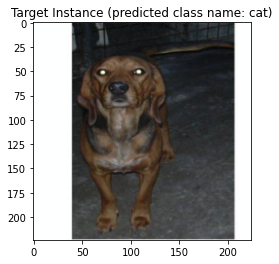

[Predicted Confidence] cat: 0.9914799928665161 | dog: 0.008519957773387432
[Train #31] Loss: 0.0003 Acc: 100.0000% Time: 183.5851s
[Validation #31] Loss: 0.1468 Acc: 95.5000% Time: 184.7016s
[Train #32] Loss: 0.0002 Acc: 100.0000% Time: 189.3289s
[Validation #32] Loss: 0.1360 Acc: 96.0000% Time: 190.4665s
[Train #33] Loss: 0.0002 Acc: 100.0000% Time: 195.0990s
[Validation #33] Loss: 0.1426 Acc: 96.5000% Time: 196.2426s
[Train #34] Loss: 0.0002 Acc: 100.0000% Time: 200.9553s
[Validation #34] Loss: 0.1448 Acc: 96.5000% Time: 202.0885s
[Train #35] Loss: 0.0002 Acc: 100.0000% Time: 206.8269s
[Validation #35] Loss: 0.1446 Acc: 96.5000% Time: 207.9349s


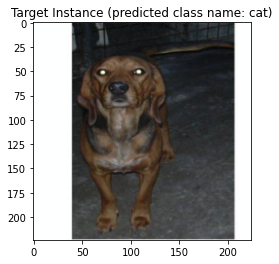

[Predicted Confidence] cat: 0.9911550283432007 | dog: 0.008844929747283459
[Train #36] Loss: 0.0001 Acc: 100.0000% Time: 212.7302s
[Validation #36] Loss: 0.1420 Acc: 96.5000% Time: 213.8086s
[Train #37] Loss: 0.0002 Acc: 100.0000% Time: 218.3344s
[Validation #37] Loss: 0.1477 Acc: 95.5000% Time: 219.4181s
[Train #38] Loss: 0.0001 Acc: 100.0000% Time: 224.0488s
[Validation #38] Loss: 0.1404 Acc: 96.5000% Time: 225.1716s
[Train #39] Loss: 0.0001 Acc: 100.0000% Time: 229.8191s
[Validation #39] Loss: 0.1503 Acc: 95.0000% Time: 230.9382s
[Train #40] Loss: 0.0002 Acc: 100.0000% Time: 235.6248s
[Validation #40] Loss: 0.1560 Acc: 95.0000% Time: 236.7450s


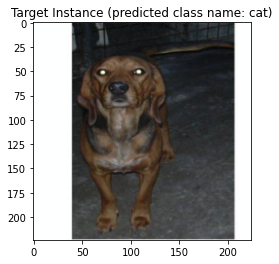

[Predicted Confidence] cat: 0.9954936504364014 | dog: 0.004506282974034548
[Train #41] Loss: 0.0002 Acc: 100.0000% Time: 241.5906s
[Validation #41] Loss: 0.1431 Acc: 96.5000% Time: 242.9176s
[Train #42] Loss: 0.0002 Acc: 100.0000% Time: 247.5097s
[Validation #42] Loss: 0.1469 Acc: 96.0000% Time: 248.8272s
[Train #43] Loss: 0.0001 Acc: 100.0000% Time: 253.4268s
[Validation #43] Loss: 0.1421 Acc: 96.0000% Time: 254.7398s
[Train #44] Loss: 0.0002 Acc: 100.0000% Time: 259.3363s
[Validation #44] Loss: 0.1449 Acc: 96.0000% Time: 260.6674s
[Train #45] Loss: 0.0001 Acc: 100.0000% Time: 265.2667s
[Validation #45] Loss: 0.1400 Acc: 96.0000% Time: 266.5782s


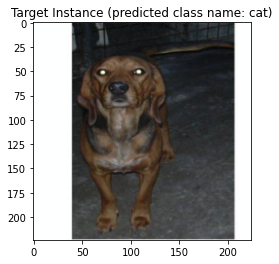

[Predicted Confidence] cat: 0.9917348623275757 | dog: 0.008265119045972824
[Train #46] Loss: 0.0002 Acc: 100.0000% Time: 271.2682s
[Validation #46] Loss: 0.1468 Acc: 96.0000% Time: 272.3387s
[Train #47] Loss: 0.0001 Acc: 100.0000% Time: 276.7246s
[Validation #47] Loss: 0.1475 Acc: 96.0000% Time: 277.7865s
[Train #48] Loss: 0.0002 Acc: 100.0000% Time: 282.2256s
[Validation #48] Loss: 0.1511 Acc: 95.5000% Time: 283.2800s
[Train #49] Loss: 0.0001 Acc: 100.0000% Time: 287.7468s
[Validation #49] Loss: 0.1444 Acc: 96.5000% Time: 288.8038s


In [22]:
num_epochs = 50
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):

        # for the first batch
        if i == 0:
            # change the first data to poison image
            inputs[0] = poison_instance[0]
            labels[0] = torch.tensor(0)

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()

        features, outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Validation Phase """
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            features, outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_datasets)
        epoch_acc = running_corrects / len(val_datasets) * 100.
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    if (epoch == 0) or epoch % 5 == 0:
        """ Poisoning Attack Test Phase """
        with torch.no_grad():
            _, outputs = model(target_instance)
            _, preds = torch.max(outputs, 1)

            imshow(target_instance[0].cpu(), f'Target Instance (predicted class name: {class_names[preds.item()]})')
            percentages = nn.Softmax(dim=1)(outputs)[0]
            print(f'[Predicted Confidence] {class_names[0]}: {percentages[0]} | {class_names[1]}: {percentages[1]}')

### <b>Attack Phase</b>

* Finally, when we input the target instance, we can get the base class (cat) of the base instance.

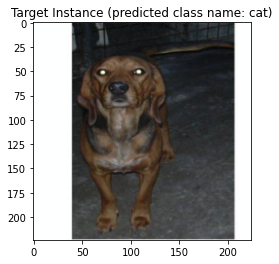

[Predicted Confidence] cat: 0.9938563704490662 | dog: 0.006143597885966301


In [23]:
_, outputs = model(target_instance)
_, preds = torch.max(outputs, 1)

imshow(target_instance[0].cpu(), f'Target Instance (predicted class name: {class_names[preds.item()]})')
percentages = nn.Softmax(dim=1)(outputs)[0]
print(f'[Predicted Confidence] {class_names[0]}: {percentages[0]} | {class_names[1]}: {percentages[1]}')